# Learning rate finder (from scratch)
> Tunning hyperparameter for better results

- toc: true 
- badges: true
- comments: true
- categories: [deep learning (DL)]

Learning rate (LR) is maybe the most important hyperparameter for our neural networks because it has the biggest impact on the result. Learning rate plays its role during backpropagation when we are moving parameters (like weights) to minimize a loss in gradient descent. If we choose a learning rate too high, it won't decrease to a global minimum and if our learning rate is too small, then it will get stuck in a local minimum.

Source: https://www.bdhammel.com/learning-rates/


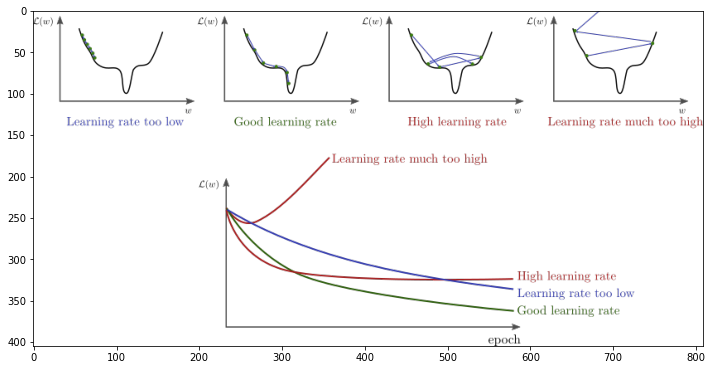

In [1]:
#hide-input
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('../images/learning_rate-dl.png')
plt.figure(figsize=(12, 10))
plt.imshow(img)
print("Source: https://www.bdhammel.com/learning-rates/")

To find the right learning rate, we can use the learning rate finder. Idea is that we will start with a small learning rate, and with every training cycle we will increase it and see how it affected loss.

The type I will go with is exponential and I will try it on a small neural network designed for MNIST classification [(wrote about it)](https://ludius0.github.io/my-blog/ai/deep%20learning%20(dl)/2020/12/14/Neural-network-from-scratch.html). Code is written for Pytorch, but it can be easily applied for other deep learning libraries.

So first, we have to import some things.

## Preparing Imports, Data and Model

Import modules:

In [2]:
#hide-output
import torch # DL library
import torch.nn as nn
import torchvision.datasets as datasets # get dataset
from tqdm.notebook import trange, tqdm # for fancy loading bar

Get dataset

In [3]:
#hide-output
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)
X_train, Y_train = mnist_trainset.data.float(), mnist_trainset.targets
X_test, Y_test = mnist_testset.data.float(), mnist_testset.targets

Define model (and create training loop)

In [4]:
torch.manual_seed(1337) # set randomness
class TorchNet(nn.Module):
    def __init__(self):
        super(TorchNet, self).__init__()
        self.l1 = nn.Linear(784, 256, bias=False)
        self.l2 = nn.Linear(256, 10)
        self.sm = nn.LogSoftmax(dim=1)
        self.act = nn.ReLU()
    def forward(self, x):
        x = self.act(self.l1(x))
        x = self.sm(self.l2(x))
        return x
model = TorchNet()
loss_f = nn.NLLLoss(reduction='none')
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)
BS=128

In [5]:
#collapse-hide
losses, accuracies = [], []
for i in (t := trange(1000)):
    # Create Batch (randomly initiated)
    samp = torch.randint(len(mnist_trainset), (BS,))
    X, Y = X_train[samp].reshape(BS, 28*28), Y_train[samp]
    
    # Pass through Net (+ calculate loss)
    output = model(X)
    loss = loss_f(output, Y).mean()
    
    # Update parameters
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    # Save for statistic
    cat = torch.argmax(output, dim=1)
    acc = (cat == Y).float().mean()
    accuracies.append(acc.item())
    losses.append(loss.item())
    
    t.set_description(f"Loss: {loss:.5f}; Acc: {acc:.5f}")
## Evaluation
Y_test_preds = torch.argmax(model.forward(X_test.reshape((-1, 28*28))), dim=1)
true_acc = (Y_test == Y_test_preds).float().mean()
print(f"Accuracy on testing set: {100 * true_acc:.5f}%")

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy on testing set: 94.00000%


this neural network during training (in 1000 range loop) is able to train to `94%` accuracy, but we can find a better learning rate for this model.

## Creating learning rate finder (exponencial)

First, we need to define a range, where we will be looking for optimal learning rate:

In [6]:
#hide
model = TorchNet()
loss_f = nn.NLLLoss(reduction='none')
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)
BS=128

In [7]:
start_lr = 1e-6; end_lr = 1

we can define it in `find_lr function`, we will also need to input to the function: **model**, **loss function**, **optimizer**, and **batch (BS)** because we will be updating the model during loop and track loss for selected learning rate.

In [8]:
def find_lr(model, loss_f, optim, start_lr=10e-7, end_lr=1, BS=128):
    if start_lr > end_lr: return
    loss_list, lr_list = [], []

We need to define a number of iteration, it will set how many learning rates we will try. This number can be chosen manually for own preference, but we can define it dependently on the length of training size divided by batches.

In [9]:
num_iter = len(X_train) // BS
num_iter

468

We then create `lr_factor`, which by multiplying with starting learning rate will be increasing and we can create a list of all learning rates from starting learning rate to ending learning rate in the range of the number of iterations. For that, we need to use exponential and logarithm functions (this concept is similar to the Softmax function).

In [10]:
#hide-output
from math import exp, log

In [11]:
#hide-output
lr_factor = exp(log(end_lr / start_lr) / num_iter)
lrs = [start_lr]
for _ in range(num_iter): lrs.append(lrs[-1] * lr_factor)

If we check it,

In [12]:
len(lrs), (lrs[0], lrs[-1]), lrs[0:4], lrs[0]*lr_factor

(469,
 (1e-06, 1.0000000000000153),
 [1e-06, 1.02996036580999e-06, 1.0608183551394486e-06, 1.0926008611173784e-06],
 1.02996036580999e-06)

we can see that length is the same as `num_iter`, it start and end with our defined range and by multiplying with `lr_factor`, we are increasing it.

We just need to recreate the training loop, update the learning rate every iteration, and track loss with the learning rate.

In [13]:
#hide
loss_list = []

In [14]:
for curr_lr in lrs:
    optim.param_groups[0]['lr'] = curr_lr # update learning rate in optimizer

    # Create Batch (randomly initiated)
    samp = torch.randint(len(mnist_trainset), (BS,))
    X, Y = X_train[samp].reshape(BS, 28*28), Y_train[samp]

    # Pass to NN
    output = model(X)
    loss = loss_f(output, Y).mean()

    # Update parameters
    optim.zero_grad()
    loss.backward()
    optim.step()

    # Save data
    loss_list.append(log(loss.item()))

Not much has changed, we also use log operation for loss to get smaller values to have a smaller graph later. Because we have already a list of all learning rates (`lrs`), we don't need to keep track of it.

Let's plot it:

In [15]:
import matplotlib.pyplot as plt

In [16]:
def plot_lr_find(loss_list, lr_list):
    fig, ax = plt.subplots(1,1)
    ax.plot(lr_list, loss_list)
    ax.set_ylabel("Loss")
    ax.set_xlabel("Learning Rate (log scale)")
    ax.set_xscale('log')
    plt.show()

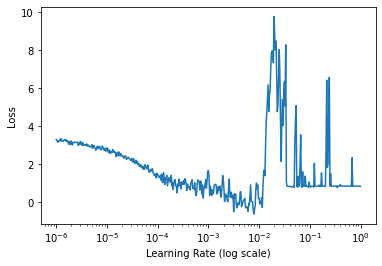

In [17]:
plot_lr_find(loss_list, lrs)

We are looking for an area, where is the biggest decrease in loss (steepest point). It means it "jump" most optimally in gradient descent. It doesn't seem obvious, but the area between 10e-4 and 10e-3 should be best (the area between 10e-2 to 10e-0 is worst because it's too high to fall into the global minimum or decent local minimum). A good rule of thumb is to choose the lowest point and divide it by ten or we can find the steepest point by computing slope, which takes two points (coordination).

$$slope = \frac{y2-y1}{x2-x1} $$

We can do both effectively in NumPy.

In [18]:
import numpy as np

In [19]:
def get_steepest_point(losses, lrs):
    losses, lrs = np.array(loss_list), np.array(lrs)
    grads = (losses[1:]-losses[:-1]) / (np.log(lrs[1:])-np.log(lrs[:-1])) 
    return (lrs[grads.argmin()].item(), lrs[losses.argmin()].item()/10.)

> Note: We already have saved losses after logarithm operations, so we need to use np.log on learning rates.

In [20]:
steepest_p, lowest_p = get_steepest_point(losses, lrs)
steepest_p, lowest_p

(0.03354602185954082, 0.0007896522868499807)

After some experimenting I have found that even the steepest point should be divided by ten and this method can be quite inaccurate for small neural networks (like with only one hidden layer), so if we would scale up our model (with hidden layers),

In [21]:
#collapse
class TorchNet(nn.Module):
    def __init__(self):
        super(TorchNet, self).__init__()
        self.l1 = nn.Linear(784, 1024, bias=False)
        self.l2 = nn.Linear(1024, 512, bias=False)
        self.l3 = nn.Linear(512, 256, bias=False)
        self.l4 = nn.Linear(256, 128, bias=False)
        self.l5 = nn.Linear(128, 64, bias=False)
        self.l6 = nn.Linear(64, 10)
        self.sm = nn.LogSoftmax(dim=1)
        self.act = nn.ReLU()
    def forward(self, x):
        x = self.act(self.l1(x))
        x = self.act(self.l2(x))
        x = self.act(self.l3(x))
        x = self.act(self.l4(x))
        x = self.act(self.l5(x))
        x = self.sm(self.l6(x))
        return x

we get more accurate results

Steepest: 0.0146780; Lowest: 0.0151178


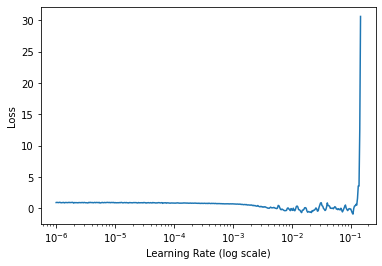

In [22]:
#hide-input
model = TorchNet()
loss_function = nn.NLLLoss(reduction='none')
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)
BS=128
def get_steepest_point(losses, lrs):
    grads = (losses[1:]-losses[:-1]) / (np.log(lrs[1:])-np.log(lrs[:-1]))
    return (lrs[grads.argmin()].item()/10., lrs[losses.argmin()].item()/10.)
def plot_lr_find(loss_list, lr_list, skip_end=5):
    fig, ax = plt.subplots(1,1)
    #loss_list = (loss_list[0:-10] + loss_list[10:]) / 2.
    #lr_list = (lr_list[0:-10] + lr_list[10:]) / 2.
    ax.plot(lr_list, loss_list)
    ax.set_ylabel("Loss")
    ax.set_xlabel("Learning Rate (log scale)")
    ax.set_xscale('log')
    plt.show()
def find_lr(model, loss_f, optim, start_lr=10e-7, end_lr=1, BS=128):
    global steepest
    if start_lr > end_lr: return
    loss_list, lr_list = [], []
    num_iter = len(X_train) // BS
    lr_factor = exp(log(end_lr / start_lr) / num_iter)
    lrs = [start_lr]
    for _ in range(num_iter): lrs.append(lrs[-1] * lr_factor)
    for curr_lr in lrs:
        # rewrite lr
        optim.param_groups[0]['lr'] = curr_lr # optim.lr = lrs[idx] * lr_factor # (same)
        # Create Batch (randomly initiated)
        samp = torch.randint(len(mnist_trainset), (BS,))
        X, Y = X_train[samp].reshape(BS, 28*28), Y_train[samp]
        # Pass to NN
        output = model(X)
        loss = loss_f(output, Y).mean()
        # Update parameters
        optim.zero_grad()
        loss.backward()
        optim.step()
        # Save data
        loss_list.append(log(loss.item()))
    losses = np.array(loss_list[:-5])
    lrs = np.array(lrs[:-5])
    steepest, lowest = get_steepest_point(losses, lrs)
    print(f"Steepest: {steepest:.7f}; Lowest: {lowest:.7f}")
    plot_lr_find(losses, lrs)
find_lr(model, loss_function, optim, BS=BS)

In [23]:
#hide
model = TorchNet()
loss_function = nn.NLLLoss(reduction='none')
optim = torch.optim.SGD(model.parameters(), lr=steepest, momentum=0)
BS=128
losses, accuracies = [], []
for i in (t := trange(1000)):
    # Create Batch (randomly initiated)
    samp = torch.randint(len(mnist_trainset), (BS,))
    X, Y = X_train[samp].reshape(BS, 28*28), Y_train[samp]
    # Pass through Net (+ calculate loss)
    output = model(X)
    loss = loss_function(output, Y).mean()
    # Update parameters
    optim.zero_grad()
    loss.backward()
    optim.step()
    # Save for statistic
    cat = torch.argmax(output, dim=1)
    acc = (cat == Y).float().mean()
    accuracies.append(acc.item())
    losses.append(loss.item())
    t.set_description(f"Loss: {loss:.5f}; Acc: {acc:.5f}")
    ## Evaluation
Y_test_preds = torch.argmax(model.forward(X_test.reshape((-1, 28*28))), dim=1)
true_acc = (Y_test == Y_test_preds).float().mean()
print(f"Accuracy on testing set: {100 * true_acc:.5f}%")

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy on testing set: 96.41000%


After I plugged the steepest point I got a better accuracy of around `2%`. It seems a small change, but keep in mind that I have already guessed a strong learning rate before and this method yields me an even better learning rate.

### Alternative (One-cycle learning rate finder)

The idea of this LR finder is to generate learning rates in a cycle (in epochs), so the learning rate would get bigger and then back smaller and code for it is something like this.

In [28]:
#hide
model = TorchNet()
loss_function = nn.NLLLoss(reduction='none')
optim = torch.optim.SGD(model.parameters(), lr=steepest, momentum=0)

In [29]:
class OneCycleScheduler():
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        return rate

So if we would like to check the generations of learning rates,

In [30]:
n_epochs = 25
iter_ = len(X_train) // BS * n_epochs
onecycle = OneCycleScheduler(iter_, max_rate=10e-1, start_rate=10e-7)
check = []

for idx in range(iter_):
    curr_lr = onecycle.on_batch_begin()
    check.append(curr_lr)
print(check[::200])

[1e-06, 0.0379948829787234, 0.0759887659574468, 0.11398264893617022, 0.1519765319148936, 0.18997041489361702, 0.22796429787234043, 0.26595818085106376, 0.3039520638297872, 0.3419459468085106, 0.379939829787234, 0.4179337127659574, 0.45592759574468084, 0.4939214787234042, 0.5319153617021276, 0.569909244680851, 0.6079031276595744, 0.6458970106382979, 0.6838908936170213, 0.7218847765957447, 0.7598786595744681, 0.7978725425531915, 0.8358664255319149, 0.8738603085106383, 0.9118541914893618, 0.9498480744680852, 0.9878419574468085, 0.9741641595744681, 0.9361702765957447, 0.8981763936170213, 0.8601825106382979, 0.8221886276595745, 0.784194744680851, 0.7462008617021276, 0.7082069787234042, 0.6702130957446808, 0.6322192127659575, 0.5942253297872341, 0.5562314468085107, 0.5182375638297873, 0.48024368085106384, 0.4422497978723404, 0.4042559148936171, 0.3662620319148937, 0.3282681489361703, 0.2902742659574469, 0.25228038297872346, 0.21428650000000005, 0.17629261702127663, 0.13829873404255322, 0.100

when implemented, it gives us similar results (also here I don't divide steepest point by ten).

  0%|          | 0/5850 [00:00<?, ?it/s]

Steepest: 0.0097227; Lowest: 0.0000000


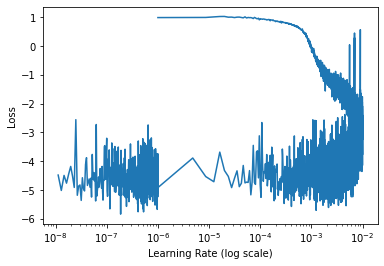

In [31]:
#collapse
def get_steepest_point(losses, lrs):
    grads = (losses[1:]-losses[:-1]) / (np.log(lrs[1:])-np.log(lrs[:-1]))
    return (lrs[grads.argmin()].item(), lrs[losses.argmin()].item()/10.)

def find_lr(model, loss_f, optim, start_lr=10e-7, end_lr=10e-3, BS=256, n_epochs=25):
    if start_lr > end_lr: return
    loss_list, lr_list = [], []
    
    iter_ = len(X_train) // BS * n_epochs
    onecycle = OneCycleScheduler(iter_, max_rate=end_lr, start_rate=start_lr)
    
    for _ in (t := trange(iter_)):
        curr_lr = onecycle.on_batch_begin()
        
        # rewrite lr
        optim.param_groups[0]['lr'] = curr_lr
        lr_list.append(curr_lr)
        
        # Create Batch (randomly initiated)
        samp = torch.randint(len(mnist_trainset), (BS,))
        X, Y = X_train[samp].reshape(BS, 28*28), Y_train[samp]
        
        # Pass to NN
        output = model(X)
        loss = loss_f(output, Y).mean()

        # Update parameters
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        # Save data
        loss_list.append(log(loss.item()))
    losses = np.array(loss_list[:-5])
    lrs = np.array(lr_list[:-5])
    steepest, lowest = get_steepest_point(losses, lrs)
    print(f"Steepest: {steepest:.7f}; Lowest: {lowest:.7f}")
    plot_lr_find(losses, lrs)
find_lr(model, loss_function, optim)

> Note: It seems that the lowest point cannot be applied for this method

## Conclusion

I hope it helped as an introduction for the learning rate finder. DL libraries like [Pytorch](https://pytorch.org/docs/stable/optim.html) and others have already implemented LR finders or you can implement them from scratch [(I have used code here)](https://github.com/ageron/handson-ml2/blob/master/11_training_deep_neural_networks.ipynb) and you can check [original paper](https://arxiv.org/pdf/1506.01186.pdf). The first DL framework implementing LR finder was [fast.ai](https://github.com/fastai/fastai) and it is most easy to use.

I have tested it on MNIST classification, but generally, it should be applicable for other types of neural networks. One-cycle seems to be more accurate (for bigger models), but also they are more computation consuming. For exponential LR finder, I have found that the steepest point (divided by ten) is more accurate than the smallest point divided by ten, but they blend together with bigger models.

Overall it is far better than guessing.